## Outline
To explore the chemical space of both train and test molecules and gain insights, I utilized [Mordred](https://github.com/mordred-descriptor/mordred)  to compute over 1,000 molecular descriptors. Subsequently, I reduced these high-dimensional vectors using PCA and t-SNE.

In [1]:
!pip install duckdb mapply rdkit mordred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.8/128.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 61.8 MB/s eta 0:00:00
  Created wheel for mordred: filename=mordred-1.2.0-py3-none-any.whl size=176721 sha256=89efa1ffef252a12192d649434b4be91d586508a3f5d4673da7c1b7a3821caee
  Stored in directory: /root/.cache/pip/wheels/a7/4f/b8/d4c6591f6ac944aaced7865b349477695f662388ad958743c7
Successfully built mordred
  Attempting uninstall: networkx
    Found existing installation: networkx 3.2.1
    Uninstalling networkx-3.2.1:
      Successfully uninstalled networkx-3.2.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
momepy 0.7.0 requ

In [2]:
from pathlib import Path
import duckdb
import pandas as pd
import numpy as np
from mordred import Calculator, descriptors

SEED = 427
datadir = Path('/kaggle/input/leash-BELKA')
belka_shrunken_dir = Path('/kaggle/input/belka-shrunken-train-set')

In [3]:
import mapply
mapply.init(
    n_workers=-1,
    progressbar=True,
)

In [4]:
from rdkit import Chem
from rdkit.Chem import AllChem
Dy = Chem.MolFromSmiles('[Dy]')
methyl = Chem.MolFromSmiles('C')
triazine = Chem.MolFromSmiles('C1=NC=NC=N1')


def replace_linker(smiles, newgroup=methyl):
    mol = Chem.MolFromSmiles(smiles)
    newmol = AllChem.ReplaceSubstructs(mol, Dy, newgroup)[0]
    Chem.SanitizeMol(newmol)
    return newmol


def from_smiles_to_3dmol(smiles, seed=SEED):
    mol = replace_linker(smiles)
    molh = Chem.AddHs(mol)
    AllChem.EmbedMolecule(molh, randomSeed=seed)
    try:
        AllChem.MMFFOptimizeMolecule(molh, maxIters=500, nonBondedThresh=200.0)
    except:
        pass
    return molh


def check_for_triazine(x):
    # https://www.kaggle.com/code/chemdatafarmer/scaffold-exploration
    check = Chem.MolFromSmiles(x).HasSubstructMatch(triazine)
    return check

## Preliminary Analysis
I generated a small dataset comprising 1,000 rows and computed its Mordred values to identify relevant descriptors.

In [5]:
try:
    train1k = pd.read_pickle('train1k.df.pcl.zip')
except FileNotFoundError:
    train_path = datadir/'train.parquet'
    con = duckdb.connect()
    N = 500
    train1k = (con.query(f"""(SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 1
                        ORDER BY random()
                        LIMIT {N})
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT {N})""")
               .df()
               .drop(['buildingblock1_smiles', 'buildingblock2_smiles',
                      'buildingblock3_smiles'], axis=1)
               .set_index('id')
               .sort_index()
               )
    con.close()
    train1k.to_pickle('train1k.df.pcl.zip')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [6]:
try:
    mordred_train1k = pd.read_pickle('mordred_train1k.df.pcl.zip')
except FileNotFoundError:
    calc = Calculator(descriptors, ignore_3D=False)
    mols = train1k.molecule_smiles.mapply(from_smiles_to_3dmol)
    mordred_train1k = calc.pandas(mols).select_dtypes('number')
    mordred_train1k.to_pickle('mordred_train1k.df.pcl.zip')

  0%|          | 0/10 [00:00<?, ?it/s]

 45%|████▌     | 452/1000 [03:01<06:26,  1.42it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1000/1000 [06:45<00:00,  2.47it/s]


Out of the 1,488 Mordred descriptors, 159 had a single unique value across the dataset and were thus considered uninformative for further analyses. I proceeded with the remaining 1,329 descriptors in subsequent analyses.

In [7]:
calc = Calculator(descriptors, ignore_3D=False)
n_unique = mordred_train1k.nunique()
usecols = list(n_unique[n_unique > 1].index)
my_descs = []
for i, desc in enumerate(calc.descriptors):
    if desc.__str__() in usecols:
        my_descs.append(desc)
print(f'#columns:{mordred_train1k.shape[1]}')
print(f'#columns with 2 or more values: {len(usecols)}')

#columns:1488
#columns with 2 or more values: 1329


Text(0.5, 1.0, 'Mordred descriptors')

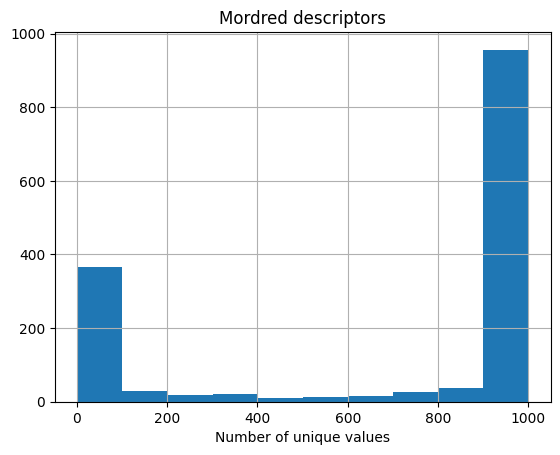

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
n_unique.hist(ax=ax)
ax.set_xlabel('Number of unique values')
ax.set_title('Mordred descriptors')

## Analyses
I sampled the following groups of molecules for my analyses.
- ~1,000 train molecules each positive for one of the three proteins
- 3,000 train molecules negative for all the three proteins
- 1,000 test molecules with the triazine core and shared or non-shared building blocks each
- 1,000 test molecules with non-triazine cores and non-shared building blocks

In [9]:
def get_mordred(smiles_ser, descs=descriptors):
    calc = Calculator(descs)
    mols = smiles_ser.mapply(from_smiles_to_3dmol)
    return calc.pandas(mols).select_dtypes('number')

In [10]:
import pickle
belka_shrunken_dir = Path('/kaggle/input/belka-shrunken-train-set')
BB1train = pickle.load(
    open(belka_shrunken_dir/'train_dicts/BBs_dict_1.p', 'br'))
BB2train = pickle.load(
    open(belka_shrunken_dir/'train_dicts/BBs_dict_2.p', 'br'))
BB3train = pickle.load(
    open(belka_shrunken_dir/'train_dicts/BBs_dict_3.p', 'br'))
BB1test = pickle.load(
    open(belka_shrunken_dir/'test_dicts/BBs_dict_1_test.p', 'br'))
BB2test = pickle.load(
    open(belka_shrunken_dir/'test_dicts/BBs_dict_2_test.p', 'br'))
BB3test = pickle.load(
    open(belka_shrunken_dir/'test_dicts/BBs_dict_3_test.p', 'br'))

In [11]:
N = 1000
try:
    train = pd.read_pickle('train.df.pcl.zip')
except FileNotFoundError:
    train_path = datadir/'train.parquet'
    protein_names=['BRD4','HSA','sEH']
    con = duckdb.connect()
    selected_ids = (con.query("""UNION ALL
            """.join([f"""(SELECT *
            FROM parquet_scan('{train_path}')
            WHERE protein_name = '{protein_name}' AND binds = 1
            ORDER BY random()
            LIMIT {N})
            """ for protein_name in protein_names])+
            f"""
            UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE protein_name = 'sEH' AND binds = 1
                        ORDER BY random()
                        LIMIT {N})
                        UNION ALL
                        (SELECT *
                        FROM parquet_scan('{train_path}')
                        WHERE binds = 0
                        ORDER BY random()
                        LIMIT {3*N})""")
                    .df()
                    ['id']
                    )

    con.close()
    userows = sorted(
        set(np.hstack([3*(selected_ids.values//3) + k for k in range(3)])))

    train = (pd.read_parquet(train_path,
                             columns=['id', 'molecule_smiles',
                                      'protein_name', 'binds'],
                             filters=[('id', 'in', userows)])
             .astype({'binds': 'boolean'})
             .assign(**{'id': lambda df: 3*(df.id//3)})
             .pivot(index=['id', 'molecule_smiles'], columns='protein_name', values='binds')
             .reset_index(level=1))
    train.to_pickle('train.df.pcl.zip')

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [12]:
try:
    test = pd.read_pickle('test.df.pcl.zip')
except FileNotFoundError:
    trainBBs = set(BB1train.keys()).union(
        BB2train.keys()).union(BB3train.keys())
    test = (pd.read_parquet(datadir/'test.parquet')
            .drop_duplicates(subset=['molecule_smiles'])
            .assign(BB1shared=lambda df: df.buildingblock1_smiles.isin(trainBBs),
                    BB2shared=lambda df: df.buildingblock2_smiles.isin(
                        trainBBs),
                    BB3shared=lambda df: df.buildingblock3_smiles.isin(
                        trainBBs),
                    triazine=lambda df: df.molecule_smiles.mapply(check_for_triazine))
            .drop(['buildingblock1_smiles', 'buildingblock2_smiles',
                   'buildingblock3_smiles', 'protein_name'],
                  axis=1))
    test.to_pickle('test.df.pcl.zip')

  0%|          | 0/24 [00:00<?, ?it/s]

### Test molecules breakdown
In each test molecule, the three building blocks are either shared or not shared at all. Also, all the molecules with non-traizine cores have non-shared building blocks.

In [13]:
breakdown = test.groupby(
    ['BB1shared', 'BB2shared', 'BB3shared', 'triazine']).size().sort_values()
breakdown

BB1shared  BB2shared  BB3shared  triazine
False      False      False      True         22593
True       True       True       True        369039
False      False      False      False       486390
dtype: int64

Text(0.5, 1.0, 'Test dataset')

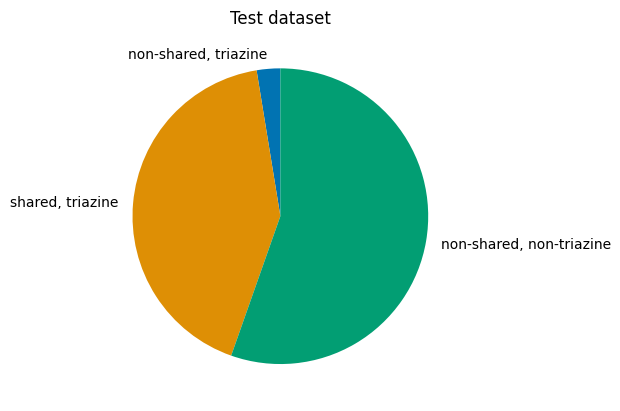

In [14]:
import seaborn as sns
fig, ax = plt.subplots()
ax.pie(breakdown,
       labels=['non-shared, triazine', 'shared, triazine',
               'non-shared, non-triazine'],
       startangle=90, colors=sns.color_palette('colorblind'))
ax.set_title('Test dataset')

In [15]:
shared_triazine = test[test.BB1shared & test.triazine].sample(
    n=N, random_state=SEED).sort_index()
nonshared_triazine = test[~test.BB1shared & test.triazine].sample(
    n=N, random_state=SEED).sort_index()
nonshared_nontriazine = test[~test.BB1shared & ~test.triazine].sample(
    n=N, random_state=SEED).sort_index()

In [16]:
names = ['train', 'shared_triazine',
         'nonshared_triazine', 'nonshared_nontriazine']
for name in names:
    try:
        exec(f'mordred_{name}=pd.read_pickle("mordred_{name}.df.pcl.zip")')
    except FileNotFoundError:
        exec(
            f'mordred_{name}=get_mordred({name}.molecule_smiles,descs=my_descs)')
        exec(f'mordred_{name}.to_pickle("mordred_{name}.df.pcl.zip")')

  0%|          | 0/24 [00:00<?, ?it/s]

 56%|█████▌    | 3894/6998 [24:11<19:02,  2.72it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 87%|████████▋ | 6121/6998 [38:41<10:22,  1.41it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 6998/6998 [44:41<00:00,  2.61it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

 88%|████████▊ | 884/1000 [05:49<01:01,  1.87it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1000/1000 [06:35<00:00,  2.53it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

 31%|███       | 310/1000 [01:58<06:14,  1.84it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 91%|█████████ | 910/1000 [05:44<00:37,  2.43it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 97%|█████████▋| 973/1000 [06:08<00:17,  1.52it/s]

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [06:52<00:00,  2.42it/s]


In [17]:
commoncols = list(set(mordred_train.columns)
                  .intersection(mordred_shared_triazine.columns)
                  .intersection(mordred_nonshared_triazine.columns)
                  .intersection(mordred_nonshared_nontriazine.columns))

In [18]:
mordred = (pd.concat([mordred_train.assign(group='train'),
                      mordred_shared_triazine.assign(group='shared, triazine'),
                      mordred_nonshared_triazine.assign(
    group='non-shared, tirazine'),
    mordred_nonshared_nontriazine.assign(group='non-shared, non-triazine')])
    [commoncols+['group']]
    .sample(frac=1, random_state=SEED)
)
groups = ['train', 'shared, triazine', 'non-shared, tirazine',
          'non-shared, non-triazine']

### PCA

#### Train molecules
When examining the molecules positive for each protein, distinct patterns emerged in the principal component analysis (PCA).


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler = StandardScaler()
n_components = 2
pca = PCA(n_components=n_components)
X = (pd.DataFrame(pca.fit_transform(scaler.fit_transform(mordred.drop('group', axis=1))),
                  index=mordred.index,
                  columns=[f'pc{k+1}' for k in range(n_components)])
     .merge(mordred.group, left_index=True, right_index=True)
     )

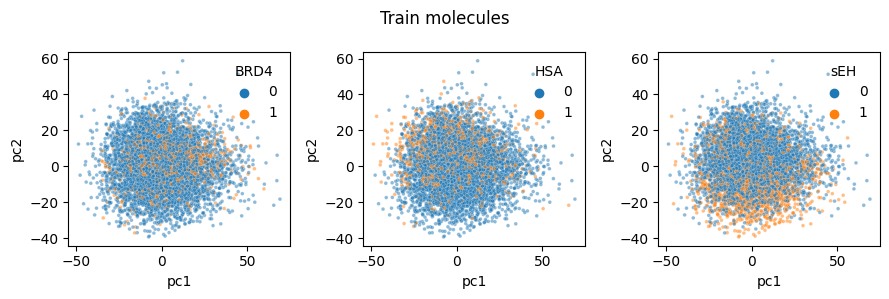

In [20]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams.update({'legend.frameon': False,
                'legend.edgecolor': 'none'})
bincolors = [sns.color_palette('colorblind')[k] for k in [7,3]]
fig = plt.figure(figsize=(9, 3))
for i, protein in enumerate(['BRD4', 'HSA', 'sEH']):
    ax = fig.add_subplot(1, 3, i+1)
    sns.scatterplot(ax=ax, data=X.loc[train.index], x='pc1',
                    y='pc2', s=7, hue=train[protein].astype('int'), alpha=.5)
fig.suptitle('Train molecules')
plt.tight_layout()

#### Train vs. test molecues
Overall, these protein groups did not exhibit any discernible distribution patterns in the figure

<Axes: xlabel='pc1', ylabel='pc2'>

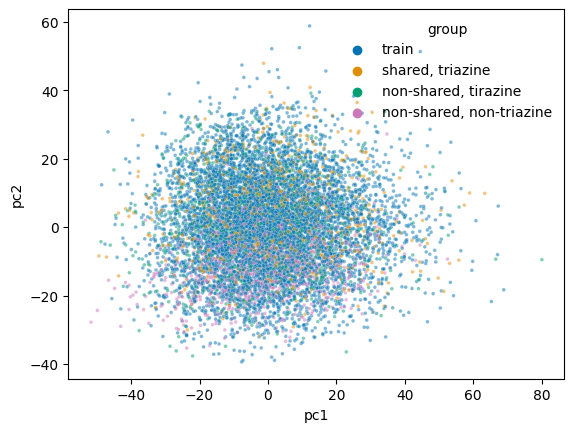

In [21]:
fig, ax = plt.subplots()
colors = [sns.color_palette('colorblind')[k] for k in [0, 1, 2, 4]]
sns.scatterplot(ax=ax, data=X, x='pc1', y='pc2', hue='group',
                hue_order=groups, s=7, palette=colors, alpha=.5)

So, I created separate plots for each group of test molecules. Those containing the triazine core overlapped significantly with the train molecules, while those with non-triazine cores were predominantly located in the lower part.

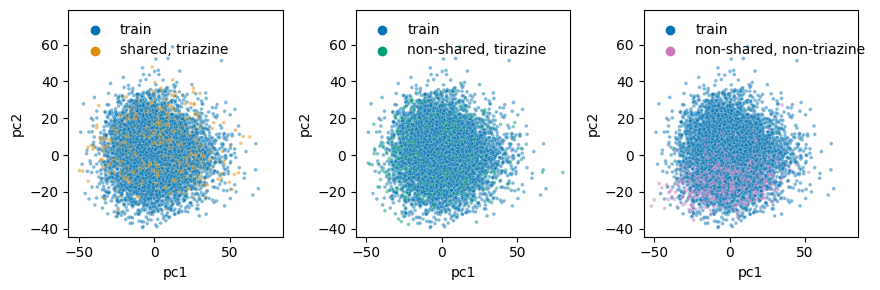

In [22]:
fig = plt.figure(figsize=(9, 3))
for i, group in enumerate(groups[1:]):
    ax = fig.add_subplot(1, 3, i+1)
    sns.scatterplot(ax=ax, data=X[lambda df:df.group.isin(['train', group])],
                    x='pc1', y='pc2', hue='group', hue_order=['train', group], s=7,
                    palette=[colors[k] for k in [0, groups.index(group)]],
                    alpha=.5)
    legend = ax.legend(loc='upper left')
    ax.set_xlim(X.pc1.min()-5, X.pc1.max()+5)
    ax.set_ylim(X.pc2.min()-5, X.pc2.max()+20)
plt.tight_layout()

### t-SNE

In [23]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=SEED)
Xtsne = (pd.DataFrame(
    tsne.fit_transform(scaler.fit_transform(mordred.drop('group', axis=1))),
    index=mordred.index,
    columns=['tsne1', 'tsne2'])
    .merge(mordred.group, left_index=True, right_index=True))

#### Train molecules

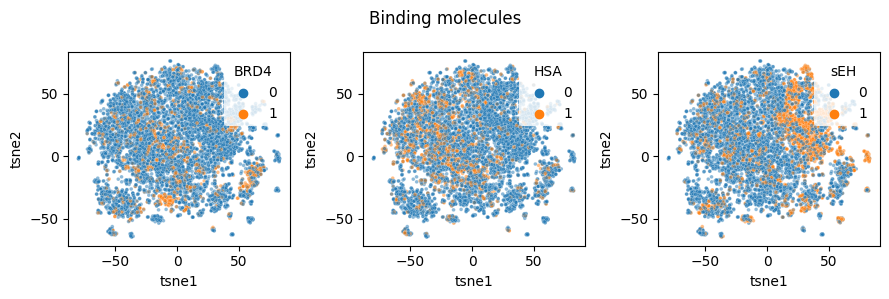

In [24]:
rcParams.update({'legend.frameon': True})
fig = plt.figure(figsize=(9, 3))
for i, protein in enumerate(['BRD4', 'HSA', 'sEH']):
    ax = fig.add_subplot(1, 3, i+1)
    sns.scatterplot(ax=ax, data=Xtsne.loc[train.index], x='tsne1',
                    y='tsne2', s=7, hue=train[protein].astype('int'), alpha=.5)
fig.suptitle('Binding molecules')
plt.tight_layout()

#### Train vs. test molecues
Wait a minute! Test molecules with non-shared BB and non-triazine cores exhibited distinct characteristics compared to both the train molecules and the test molecules in the other groups.

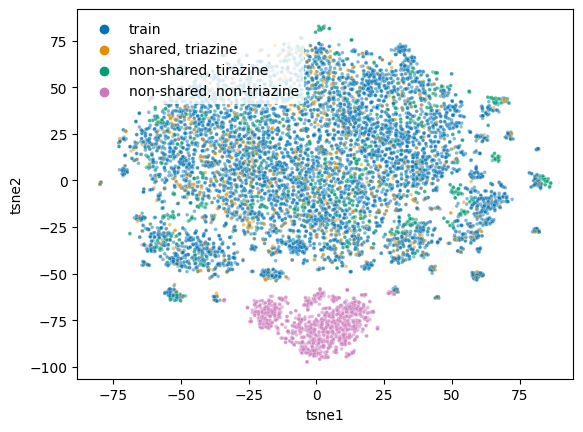

In [25]:
fig, ax = plt.subplots()
sns.scatterplot(ax=ax, data=Xtsne, x='tsne1', y='tsne2', hue='group',
                hue_order=groups, s=7, palette=colors, alpha=.5)
legend = ax.legend(loc='upper left')

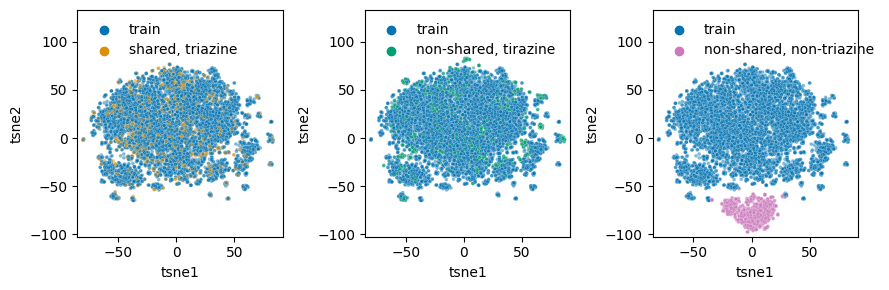

In [26]:
rcParams.update({'legend.frameon': False})
fig = plt.figure(figsize=(9, 3))
for i, group in enumerate(groups[1:]):
    ax = fig.add_subplot(1, 3, i+1)
    sns.scatterplot(ax=ax, data=Xtsne[lambda df:df.group.isin(['train', group])],
                    x='tsne1', y='tsne2', hue='group', hue_order=['train', group], s=7,
                    palette=[colors[k] for k in [0, groups.index(group)]],
                    alpha=.5)
    legend = ax.legend(loc='upper left')
    ax.set_xlim(Xtsne.tsne1.min()-5, Xtsne.tsne1.max()+5)
    ax.set_ylim(Xtsne.tsne2.min()-5, Xtsne.tsne2.max()+50)
plt.tight_layout()

## Conclusion
In the chemical space, molecules binding to each protein exhibited distinct patterns, which is promising. However, test molecules with non-triazine cores appeared isolated from other molecules, particularly in t-SNE. This observation may explain why they pose significant challenges.